In [1]:
import pyzed.sl as sl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
svo_path = '../data/Schlieren/svo/HD1080_SN35520970_11-03-24.svo'

In [3]:
zed = sl.Camera()

# init parameters
init_params = sl.InitParameters()
init_params.set_from_svo_file(svo_path)
init_params.depth_mode = sl.DEPTH_MODE.ULTRA
init_params.coordinate_units = sl.UNIT.METER
init_params.depth_maximum_distance = 40
init_params.depth_minimum_distance = 1
init_params.sdk_verbose = True

zed.open(init_params)

SUCCESS

In [4]:
calibration_frames = 30
skip_frames = 25

In [5]:
runtime_parameters = sl.RuntimeParameters()
temp_image_left = sl.Mat()
temp_image_right = sl.Mat()

In [6]:
color_array_l = np.zeros((1080, 1920, 3, calibration_frames))
color_array_r = np.zeros((1080, 1920, 3, calibration_frames))

In [7]:
for i in range(calibration_frames * skip_frames):
    zed.grab(runtime_parameters)
    if i % skip_frames != 0:
        continue
    frame_nr = zed.get_svo_position()
    # zed.retrieve_measure(image, sl.MEASURE.DEPTH)
    zed.retrieve_image(temp_image_left, sl.VIEW.LEFT)
    current_frame_l = temp_image_left.get_data()[:, :, :3]
    color_array_l[:, :, :, i // skip_frames] = current_frame_l
    zed.retrieve_image(temp_image_right, sl.VIEW.RIGHT)
    current_frame_r = temp_image_right.get_data()[:, :, :3]
    color_array_r[:, :, :, i // skip_frames] = current_frame_r

In [8]:
# get median depth
median_depth_l = np.nanmedian(color_array_l, axis=3)
median_depth_r = np.nanmedian(color_array_r, axis=3)

In [9]:
print(median_depth_l.shape)
print(median_depth_r.shape)

(1080, 1920, 3)
(1080, 1920, 3)


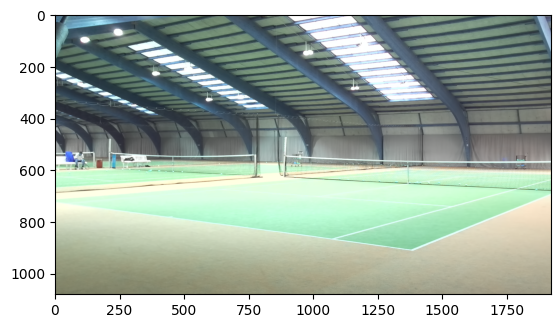

In [10]:
plt.imshow(median_depth_l.astype(np.uint8))

In [13]:
image_left = sl.Mat()
image_right = sl.Mat()

In [11]:
# init detection parameters
detection_parameters = sl.ObjectDetectionParameters()

detection_parameters.image_sync = True
detection_parameters.enable_tracking = True
detection_parameters.enable_segmentation = True

detection_parameters.detection_model = sl.OBJECT_DETECTION_MODEL.MULTI_CLASS_BOX_MEDIUM

if detection_parameters.enable_tracking:
    zed.enable_positional_tracking()

zed.enable_object_detection(detection_parameters)

detection_confidence = 20
detection_parameters_rt = sl.ObjectDetectionRuntimeParameters(detection_confidence)

detection_parameters_rt.object_class_filter = [sl.OBJECT_CLASS.PERSON, sl.OBJECT_CLASS.SPORT]

detected_objects = sl.Objects()

In [14]:
for i in range(10):
    zed.grab(runtime_parameters)
zed.retrieve_image(image_left, sl.VIEW.LEFT)
zed.retrieve_image(image_right, sl.VIEW.RIGHT)
current_frame_left = image_left.get_data()[:, :, :3]
current_frame_right = image_right.get_data()[:, :, :3]
zed.retrieve_objects(detected_objects, detection_parameters_rt)

SUCCESS

In [15]:
moving_left = current_frame_left - median_depth_l
moving_right = current_frame_right - median_depth_r

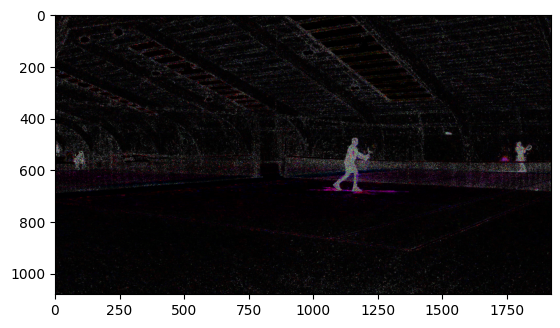

In [16]:
plt.imshow(np.square(moving_left.astype(np.uint8)))

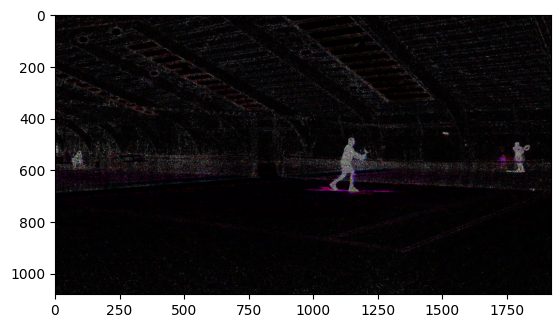

In [17]:
plt.imshow(np.square(moving_right.astype(np.uint8)))

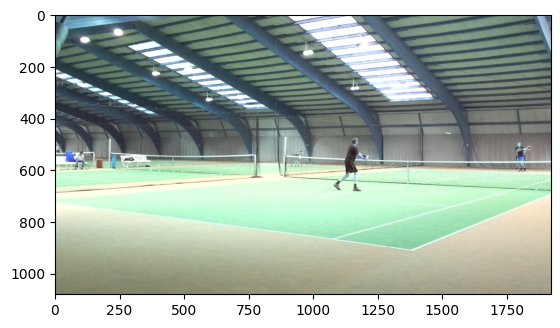

In [18]:
plt.imshow(current_frame_left.astype(np.uint8))

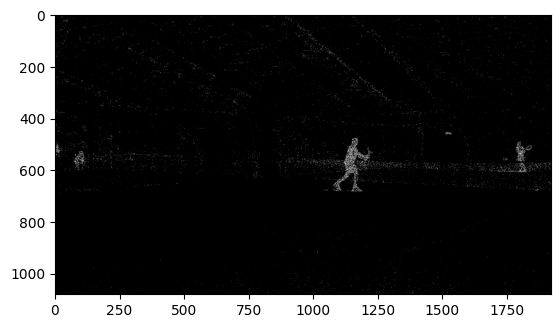

In [19]:
diff_left = np.square(moving_left.astype(np.uint8)).sum(axis=2)
plt.imshow((diff_left / diff_left.max()).round(), cmap='gray')

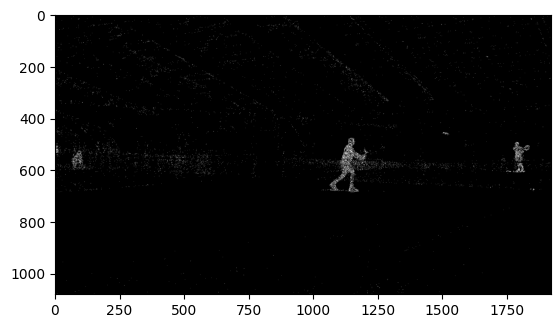

In [20]:
diff_right = np.square(moving_right.astype(np.uint8)).sum(axis=2)
plt.imshow((diff_right / diff_right.max()).round(), cmap='gray')

In [21]:
temp_image = (diff_right / diff_right.max()).round()

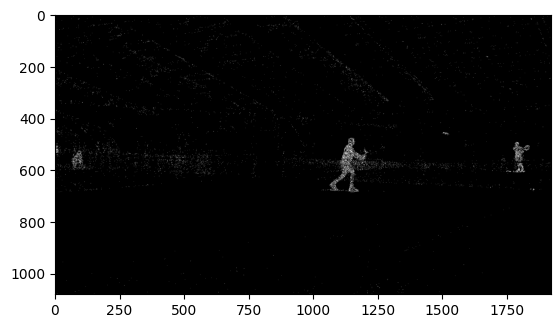

In [22]:
plt.imshow(temp_image, cmap='gray')

In [26]:
dir(detected_objects.object_list[0])

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'action_state',
 'bounding_box',
 'bounding_box_2d',
 'confidence',
 'dimensions',
 'head_bounding_box',
 'head_bounding_box_2d',
 'head_position',
 'id',
 'label',
 'mask',
 'position',
 'position_covariance',
 'raw_label',
 'sublabel',
 'tracking_state',
 'unique_object_id',
 'velocity']

In [40]:
# create a mask for the detected object
def get_mask(index, image):
    mask = np.zeros_like(image)

    # get the bounding box
    bb = detected_objects.object_list[index].bounding_box_2d
    # array([[1077.,  475.],
    #        [1209.,  475.],
    #        [1209.,  684.],
    #        [1077.,  684.]])

    # set the mask to 1 where the bounding box is
    mask[int(bb[0][1]):int(bb[2][1]), int(bb[0][0]):int(bb[1][0])] = 1
    return mask

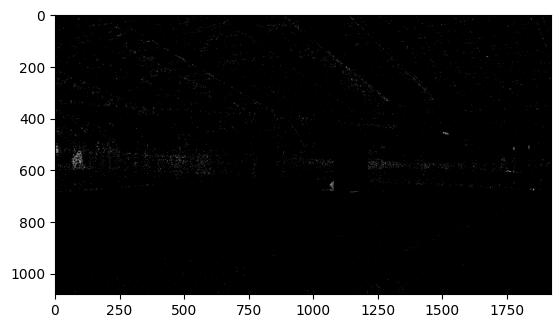

In [41]:
masked = temp_image
for i in range(len(detected_objects.object_list)):
    mask = get_mask(i, temp_image)
    masked = masked - mask
masked[masked < 0] = 0

plt.imshow(masked, cmap='gray')